In [ ]:
"""
Objectives:


1. Use different message types: HumanMessage and AIMessage
2. Maintain a full conversation history using both message types.
3. Use Claude model using LangChain.
4. Create a sophisticated conversation loop.

"""

'\nObjectives:\n\n\n1. Use different message types: HumanMessage and AIMessage\n2. Maintain a full conversation history using both message types.\n3. Use Claude model using LangChain.\n4. Create a sophisticated conversation loop.\n\n'

In [ ]:
!pip install langchain_anthropic

In [ ]:
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END

In [ ]:
from getpass import getpass
import os

# Prompt for Claude API key (input is hidden)
claude_api_key = getpass("Enter your Claude API Key: ")
os.environ["ANTHROPIC_API_KEY"] = claude_api_key


Enter your Claude API Key: ··········


In [ ]:
model = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    temperature=0.7,
    anthropic_api_key=claude_api_key  # explicitly pass the key
)

In [ ]:
class AgentState(TypedDict):
  messages: List[Union[HumanMessage, AIMessage]]

In [ ]:
def process(state: AgentState) -> AgentState:
  """ This node will solve the request you input """
  response = model.invoke(state['messages'])

  state['messages'].append(AIMessage(content = response.content))
  print(f"\nAI: {response.content}")
  print("CURRENT STATE", state['messages'])

  return state

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)

agent = graph.compile()

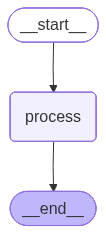

In [17]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
conversation_history = []

user_input = input("Enter: ")
while user_input != "exit":
  conversation_history.append(HumanMessage(content = user_input))

  # You pass conversation_history into the graph, LangGraph wraps it into AgentState
  # Inside the graph, state["messages"] points to the same list
  result = agent.invoke({"messages": conversation_history}) # not just the current human message, entire history
  print(result['messages']) # result is the final AgentState returned by your LangGraph.
  conversation_history = result['messages']
  user_input = input("Enter: ")

Enter: hi

AI: Hello! How are you doing today? Is there anything I can help you with?
CURRENT STATE [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! How are you doing today? Is there anything I can help you with?', additional_kwargs={}, response_metadata={})]
[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! How are you doing today? Is there anything I can help you with?', additional_kwargs={}, response_metadata={})]
Enter: hi, my name is Steve

AI: Nice to meet you, Steve! How's your day going? What brings you here today - is there something I can help you with or anything you'd like to chat about?
CURRENT STATE [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! How are you doing today? Is there anything I can help you with?', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi, my name is Steve', additional_kwargs={}, res

In [ ]:
with open("logging.txt", "w") as file:
  file.write("Your Conversation Log:\n")
  for message in conversation_history:
    if isinstance(message, HumanMessage):
      file.write(f"You: {message.content}\n")
    elif isinstance(message, AIMessage):
      file.write(f"AI: {message.content}\n")
  file.write("End of Conversation")
print("Conversation saved to logging.txt")

Conversation saved to logging.txt


In [ ]:
"""
conversation_history
    ↓ (passed into graph)
AgentState.messages
    ↓ (modified by nodes)
result["messages"]
    ↓ (copied back)
conversation_history
"""